#  WeFarm data set - Farmer ID

This notebook processes the WeFarm data set and creates a leaderboard of the top contributors.

## Definitions

In [1]:
# Set up
from pathlib import Path

ROOT_DIR = Path('').resolve()
DATA_DIR = ROOT_DIR / 'data'
RESULTS_DIR = ROOT_DIR / 'results'
DATA_FILE = DATA_DIR / 'b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv'
CSV_DELIMETER=','
QID_COL='question_id'
ATTRS=('question_language','question_topic')
FROM_COL='question_user_id'
TO_COL='response_user_id'

## Confirm directories and file

In [2]:
# Create directories if they don't exist
for directory in [DATA_DIR, RESULTS_DIR]:
    directory.mkdir(exist_ok=True)

    # print contents of data directory
    print(f"Files in '{directory}':")
    for file in directory.iterdir():
        print(f"\t{file.name}")
    print()

    print(f"Data file: {DATA_FILE}")

Files in 'C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data':
	b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv
	meeting_notes.txt
	Producers Direct DataKit Brief (external).md

Data file: C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data\b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv
Files in 'C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\results':

Data file: C:\Users\jbhan\OneDrive\Documents\Visual Studio 2019\Projects\Python\datakit-smallholder-farmers-fall-2025\Challenge 3_Community Leaders\jayr\data\b0cd514b-b9cc-4972-a0c2-c91726e6d825.csv


## Create a Multi Di Graph of the questions

In [3]:
import csv
from src.graph import MultiDiGraph

graph = MultiDiGraph()

with open(DATA_FILE, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f, delimiter=CSV_DELIMETER)

    i=0
    for row in reader:
        from_node = row[FROM_COL]
        to_node = row[TO_COL]

        i += 1
        if i > 200_000:
            break

        # Remaining columns become edge attributes
        edge_id = row[QID_COL]

        graph.add_edge(from_node, to_node, edge_id)

all_edges = graph.get_all_edges()
print(len(all_edges))

200000


In [8]:
# Delete all nodes with both indegree and outdegree less than 2
delete_nodes = []

for node in graph.nodes:
    if graph.in_degree(node) < 4 and graph.out_degree(node) < 6:
        delete_nodes.append(node)

for node in delete_nodes:
    graph.remove_node(node)

print("Nodes", len(graph.nodes))

Nodes 20217


## Get the most askers and answerers

Summary of nodes by indegree	Summary of nodes by outdegree
Min		0		0
Median		4.0		1.0
75 %ile		0		7.000
Max		1184		508
Mean		5.195		5.195
Standard Deviation	16.293		11.026
Top Answerers [1184, 1111, 746, 721, 538, 527, 467, 389, 301, 234]
Top Askers [508, 318, 239, 230, 220, 198, 198, 198, 193, 185]


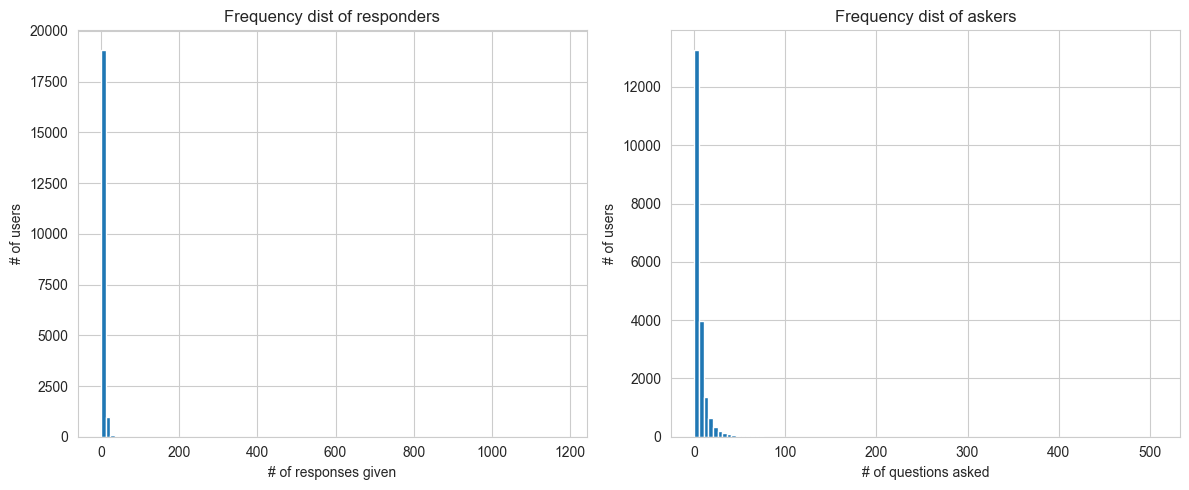

In [9]:
indegrees = [graph.in_degree(node) for node in graph.nodes]
nodes_by_indegree = sorted(indegrees, reverse=True)
outdegrees = [graph.out_degree(node) for node in graph.nodes]
nodes_by_outdegree = sorted(outdegrees, reverse=True)

# Summary of nodes by indegree
import numpy as np
print('Summary of nodes by indegree\tSummary of nodes by outdegree')
print(f'Min\t\t{min(nodes_by_indegree)}\t\t{min(nodes_by_outdegree)}')
print(f'Median\t\t{np.median(nodes_by_indegree)}\t\t{np.median(nodes_by_outdegree)}')
print(f'75 %ile\t\t{min(nodes_by_indegree)}\t\t{np.quantile(nodes_by_outdegree, 0.75):.3f}')
print(f'Max\t\t{max(nodes_by_indegree)}\t\t{max(nodes_by_outdegree)}')
print(f'Mean\t\t{np.mean(nodes_by_indegree):.3f}\t\t{np.mean(nodes_by_outdegree):.3f}')
print(f'Standard Deviation\t{np.std(nodes_by_indegree):.3f}\t\t{np.std(nodes_by_outdegree):.3f}')

print('Top Answerers', nodes_by_indegree[:10])
print('Top Askers', nodes_by_outdegree[:10])

# Display plots side by side
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(nodes_by_indegree, bins=100)
ax1.set_title('Frequency dist of responders')
ax1.set_xlabel('# of responses given')
ax1.set_ylabel('# of users')

ax2.hist(nodes_by_outdegree, bins=100)
ax2.set_title('Frequency dist of askers')
ax2.set_xlabel('# of questions asked')
ax2.set_ylabel('# of users')

plt.tight_layout()
plt.show()


In [28]:
# Create a matrix that counts how many edges exist between each pair of nodes
all_nodes = list(graph.nodes)
edges_between_nodes = [[0 for _ in range(len(all_nodes))] for _ in range(len(all_nodes))]

all_edges = graph.get_all_edges()
print(len(all_edges))

for head, tail, qid in all_edges:
    i = all_nodes.index(head)
    j = all_nodes.index(tail)
    edges_between_nodes[i][j] += 1

# Print descriptive statistics about the matrix
print("Min", np.min(edges_between_nodes))
print("Median", np.median(edges_between_nodes))
print("Max", np.max(edges_between_nodes))
print(f"Mean\tn{np.mean(edges_between_nodes):.3f}")
print(f"Standard Deviation\t{np.std(edges_between_nodes):.3f}")

MemoryError: 

In [ ]:
# Display a heatmap showing the number of edges between nodes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(edges_between_nodes, cmap='YlGnBu', cbar=False)
plt.title('Edges between nodes')
plt.show()

In [ ]:
# Convert the matrix to a pandas DataFrame
import pandas as pd

edges_df = pd.DataFrame(edges_between_nodes, index=nodes, columns=nodes)

#Remove rows and columns with all zeros
edges_df = edges_df.loc[edges_df.sum(axis=1) > 2]
edges_df = edges_df.loc[:, edges_df.sum(axis=0) > 2]
print(edges_df.shape)

# Plot the DataFrame as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(edges_df, cmap='YlGnBu', cbar=False)
plt.title('Edges between nodes')
plt.show()

In [ ]:
print(edges_df.head(5))

## 4. Data Visualization

In [ ]:
from src.visualization import setup_plot_style, plot_distributions, plot_correlation_heatmap

# Set up visualization
%matplotlib inline
setup_plot_style()

#  visualization
plot_distributions(df)
plot_correlation_heatmap(df)

## 5. Save Results

In [ ]:
# Example: Save processed data
# processed_path = RESULTS_DIR / 'processed_data.csv'
# df.to_csv(processed_path, index=False)
# print(f'Saved processed data to {processed_path}')